In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from scipy.spatial.distance import cdist

In [120]:
# Functions
def show_image(img, shape=(15, 15), img_type="bgr"):
    plt.rcParams["figure.figsize"] = shape
    if img_type == "bgr":
        plt.imshow(img[:, :, [2, 1, 0]])
    elif img_type.lower() == "gray":
        plt.imshow(img, cmap='gray')


def show_keypoints(img, keypoints):
    img = cv2.drawKeypoints(image=img, keypoints=keypoints, outImage=np.array(
        []), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    show_image(img)


def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def print_matches(matches):
    try:
        if type(matches[0]) not in (np.ndarray, list):
            for match in matches:
                print('Train=%4d Query=%4d Distance=%4.2f' %
                      (match.trainIdx, match.queryIdx, match.distance))
        else:
            for match_ in matches:
                for match in match_:
                    print('Train=%4d Query=%4d Distance=%4.2f' %
                          (match.trainIdx, match.queryIdx, match.distance))
    except:
        pass


def draw_matches(img1, img2, kp1, kp2, matches):
    img3 = cv2.drawMatches(img1, kp1, img2, kp2,
                           matches, outImg=np.array([]))  # , matchColor=(0, 255, 0))
    show_image(img3)

# https://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html


def get_sift_features(img):
    if len(img.shape) == 3:
        img = to_grayscale(img)
    sift_obj = cv2.xfeatures2d.SIFT_create()
    return sift_obj.detectAndCompute(img, None)


def get_sift_features_and_show(img, show=False):
    keypoints = get_sift_features(img)
    if(show):
        show_keypoints(img, keypoints[0])
    return keypoints


def cv_matcher(img1, desc1, img2, desc2, kp1=None, kp2=None, threshold=0.75):
    brute_force_matcher = cv2.BFMatcher()

    # Match descriptors.
    matches = brute_force_matcher.knnMatch(desc1, desc2, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < threshold * n.distance:
            good.append(m)

    if kp1 != None and kp2 != None:
        img3 = cv2.drawMatches(img1, kp1, img2, kp2,
                               good, outImg=np.array([]))  # , matchColor=(0, 255, 0))
        show_image(img3)

'''
    Gets matches for arr1 in arr2
'''
def knn_matcher(arr2, arr1, neighbours=2, img_id=0):
    assert neighbours == 2

    all_distances = np.sqrt(np.square(arr2).sum(
        axis=1)[:, np.newaxis] + np.square(arr1).sum(axis=1) - 2 * arr2.dot(arr1.T))

    closest_indices = np.argsort(all_distances, axis=1)[:, :neighbours]

    matches = []
    for i in range(closest_indices.shape[0]):
        match_list = [cv2.DMatch(
            _trainIdx=n, _queryIdx=i, _distance=all_distances[i, n], _imgIdx=img_id) for n in closest_indices[i]]
        matches.append(match_list)

    return matches


def filter_matches(matches, threshold=0.75):
    filtered = []
    for m, n in matches:
        if m.distance < threshold * n.distance:
            filtered.append(m)
    return filtered

'''
    Computes the homography matrix for the given points using 
    the Direct Linear transform
'''
def get_homography_matrix(pts1, pts2):
    eqn_list = []
    for (x1, y1), (x2, y2) in zip(pts1, pts2):
        row1 = [x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2, -x2]
        row2 = [0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2, -y2]
        eqn_list.append(row1)
        eqn_list.append(row2)

    # Solve for A.h = 0
    A = np.array(eqn_list)
#     print(A)kp1
    eig_values, eig_vectors = np.linalg.eig(np.dot(A.T, A))
    h_index = eig_values.argmin()
    h = eig_vectors[:, h_index]

    # Convert it to a unit vector
    h = h / np.linalg.norm(h)
    
    h /= h[-1]
    return h.reshape(3, 3)

In [121]:
img1 = cv2.imread("../data/nevada4.jpg")
img2 = cv2.imread("../data/nevada5.jpg")

In [122]:
keypoints1, descriptors1 = get_sift_features_and_show(img1)
keypoints2, descriptors2 = get_sift_features_and_show(img2)

In [123]:
#cv_matches = cv_matcher(img1, descriptors1, img2, descriptors2, keypoints1, keypoints2)

In [124]:
matches = filter_matches(knn_matcher(descriptors1, descriptors2))

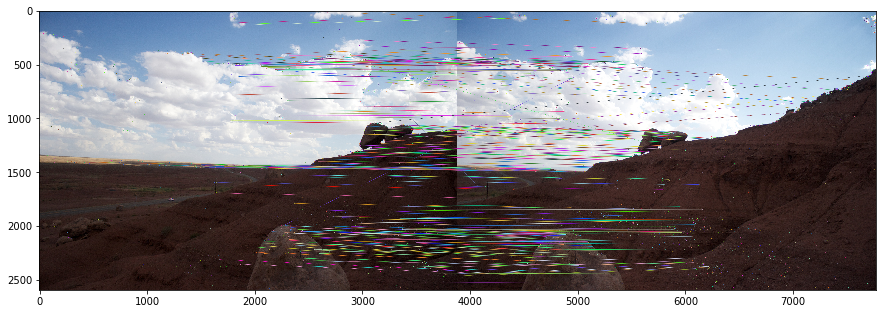

In [125]:
draw_matches(img1, img2, keypoints1, keypoints2, matches)

In [143]:
def ransac(matches, kp1, kp2, sample_points=4, iterations=5, inlier_tolerance=3, inlier_ratio=0.4, check = True):
    num_inliers = 0
    best_inlier_count = 0
    best_h = None
    
    # Get all the corresponing matching pairs for both the images
    pts1 = np.array([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.array([kp2[m.trainIdx].pt for m in matches])

    homogeneous_pts1 = np.hstack((pts1, np.ones((pts1.shape[0], 1)))).T
    indices = np.arange(len(pts1))
    num_pts = pts1.shape[0]
    
    # For number of iterations
    for i in range(iterations):
        
        # Sample a small set of points from the point match pairs
        indices_to_sample = np.random.choice(indices, sample_points)
        pts1_sample = pts1[indices_to_sample]
        pts2_sample = pts2[indices_to_sample]
        
        # Get the homography matrix
        h = get_homography_matrix(pts1_sample, pts2_sample)
        
        # Find the new points using the homography matrix
        transformed_points = np.dot(h, homogeneous_pts1).T
        
        # Convert it to world coordinates
        last_col = np.copy(transformed_points[:, -1])
        last_col = last_col[:, np.newaxis]
        transformed_points /= last_col
        transformed_points = transformed_points[:, :-1]
        
#         print(pts2[:10])
#         print(transformed_points[:10])
        distance = np.linalg.norm(pts2 - transformed_points, axis = 1)
        inlier_count = len(distance[distance < inlier_tolerance])
        if inlier_count > best_inlier_count:
            best_h = h
            best_inlier_count = inlier_count
    
#         if inlier_count > inlier_ratio * num_pts:
#             break
    
    if check:          
        transformed_points = np.dot(best_h, homogeneous_pts1).T
        # Convert it to world coordinates
        last_col = np.copy(transformed_points[:, -1])
        last_col = last_col[:, np.newaxis]
        transformed_points /= last_col
        transformed_points = transformed_points[:, :-1]
        distance = np.linalg.norm(pts2 - transformed_points, axis = 1)
        inlier_count = len(distance[distance < inlier_tolerance])
        print(best_inlier_count)
        print('Inliers are %2.2f of the points'  %(inlier_count / num_pts * 100))
    
    return best_h

In [145]:
ransac(matches, keypoints1, keypoints2, sample_points=10, iterations=10000)

191
Inliers are 40.99 of the points


array([[ 1.39080199e+00, -5.51411458e-02, -1.88869944e+03],
       [ 1.61644853e-01,  1.25922326e+00, -3.73778675e+02],
       [ 1.02851772e-04, -2.83927541e-06,  1.00000000e+00]])

In [148]:

pts1 = np.array([keypoints1[m.queryIdx].pt for m in matches])
pts2 = np.array([keypoints2[m.trainIdx].pt for m in matches])
cv2.findHomography(pts1, pts2, cv2.RANSAC)

(array([[ 1.39242611e+00, -5.63036918e-02, -1.89173794e+03],
        [ 1.62160458e-01,  1.25711397e+00, -3.72842450e+02],
        [ 1.03114645e-04, -3.65337781e-06,  1.00000000e+00]]), array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0

In [128]:
# Check for homography
a = np.array([(20, 30), (31, 18), (15, 6)])
b = np.array([(10, 20), (20, 50), (10, 90)])
h = get_homography_matrix(a, b)
res = np.dot(h, [20, 30, 1])
res /= res[-1]
print(res)

[10. 20.  1.]


In [129]:
pt = np.array([[20, 30, 1],[31, 18,1] ])

In [30]:
pt.shape

(2, 3)

In [31]:
h.shape

(3, 3)

In [41]:
z = np.dot(h, pt.T )

In [42]:
z

array([[ -5.73695594,  -0.6296691 ],
       [-11.47391188,  -1.57417274],
       [ -0.57369559,  -0.03148345]])

In [33]:
z /= z[-1]

In [39]:
z[:2,:].T

array([[10., 20.],
       [20., 50.]])